In [1]:
# install shap and xgboost
!pip install shap
!pip install xgboost
!pip install scikit-learn==0.24.2

Defaulting to user installation because normal site-packages is not writeable
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

bokeh 3.1.0 requires pandas>=1.2, but you'll have pandas 1.1.3 which is incompatible.
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip in

# Tree ensemble - Boston housing dataset

In [2]:
# verify installations
import shap
import xgboost
import sklearn
print(shap.__version__)
print(xgboost.__version__)
print(sklearn.__version__)

0.41.0
1.7.5
0.24.2


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


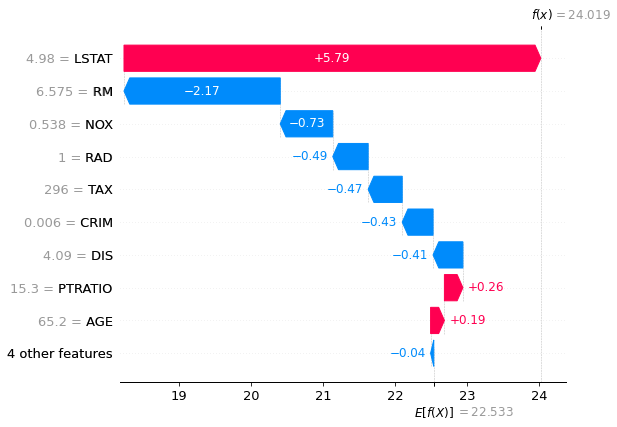

In [3]:
# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize first prediction's explanation
shap.plots.waterfall(shap_values[0])

The data above shows features that contribute to push the model output from the base value. Features that push the prediction higher are shown in red, those pushing the prediction lower are in blue.

Alternatively, another way to visualize the same explanation is to use a force plot.

In [4]:
# visualize the first prediction's explanation with a force plot
# initjs() is only needed for the notebook
shap.initjs()
shap.plots.force(shap_values[0])

It is also possible to see explanations for an entire dataset by taking many force plot explanations, rotating them 90 degrees, and stacking them horizontally.

In [5]:
# visualize all the training set predictions
shap.plots.force(shap_values)

Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as RM (average number of rooms per house in an area) changes. 

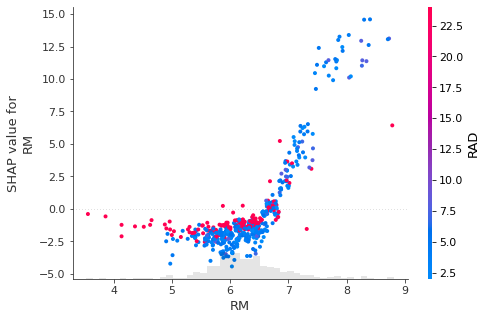

In [6]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "RM"], color=shap_values)

What this plot shows is the average number of rooms per house in an area compared to the accessibility of radial highways (RAD).

In other words, this highlights that the average number of rooms per house has less impact on home price for areas with a high RAD value.

Plot the SHAP values of every feature for every sample to get an overview of which features are most important for a model. It works because the features will be sorted by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.

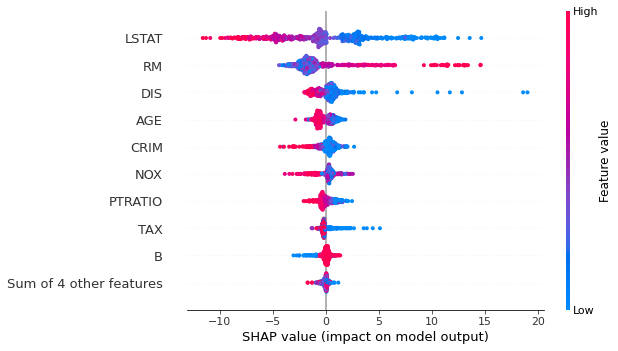

In [7]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

This shows that a high LSTAT (% lower status of the population) lowers the predicted house price. In other words, if the neighborhood is a working class neighborhood, housing prices are predicted to be lowered.

Furthermore, it is also possible to take the mean absolute value of the SHAP values for each feature to get a standard bar plot.

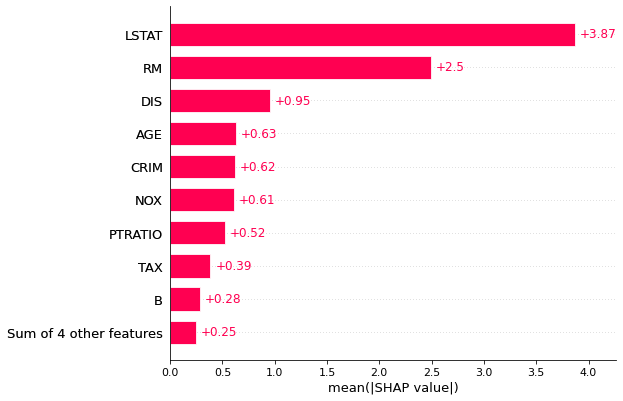

In [8]:
# create a bar plot of all the features
shap.plots.bar(shap_values)

# Calculate feature importance for both  training set and the test set

In [10]:
# import packages
import numpy as np
import pandas as pd
import shap

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

from xgboost import XGBRegressor

In [11]:
# load boston dataset
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

# split dataset into training and testing datasets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [12]:
# fit XGBoost regressor
xgb = XGBRegressor(n_estimators=100) # set number of trees to 100
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [13]:
# get feature importances from xgboost model
xgb.feature_importances_

array([0.00756926, 0.00273596, 0.01034596, 0.00192617, 0.03392044,
       0.15353625, 0.01268771, 0.06075992, 0.01933588, 0.03630253,
       0.05134816, 0.00551182, 0.60402   ], dtype=float32)

<BarContainer object of 13 artists>

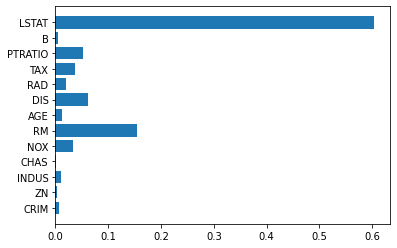

In [14]:
# visualize importances
plt.barh(boston.feature_names, xgb.feature_importances_)

Text(0.5, 0, 'XGBoost Feature Importance')

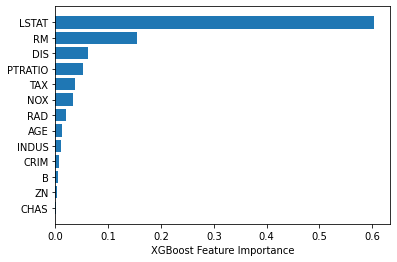

In [15]:
# sort features based on importance values
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(boston.feature_names[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel('XGBoost Feature Importance')

# Permutation Based Feature Importance

The permutation method randomly shuffles each feature and computes the change in the model's performance. The features which impact the performance the most are the most important ones.

In [16]:
# install seaborn
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 293 kB 33.5 MB/s eta 0:00:01
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [17]:
# compute permutation importance for XGBoost model
perm_importance = permutation_importance(xgb, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

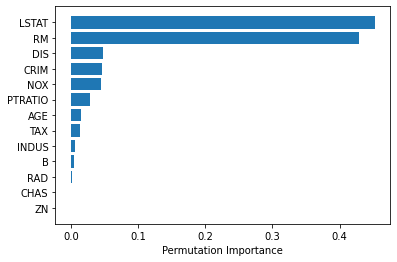

In [18]:
# visualize importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

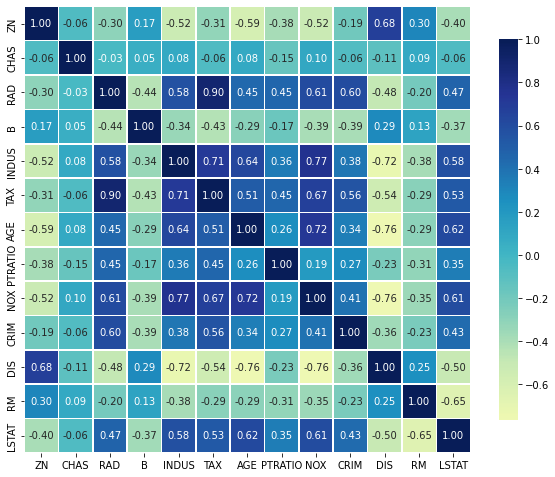

In [19]:
# check correlation in dataset
import seaborn as sns

def correlation_heatmap(train):
    correlations = train.corr()
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
               square=True, linewidths=0.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(X_train[boston.feature_names[sorted_idx]])

Based on the above results, the ZN, CHAS, AGE, INDUS can safely be removed. Their importance based on permutation is very low. Therefore, they are not highly correlated.

# Feature Importance Computed with SHAP Values

It is also possible to compute feature importance in XGBoost by using the SHAP package. It uses the Shapley values from game theory to estimate how each feature contributes to the prediction.

In [20]:
# compute feature importance in XGBoost using SHAP package
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


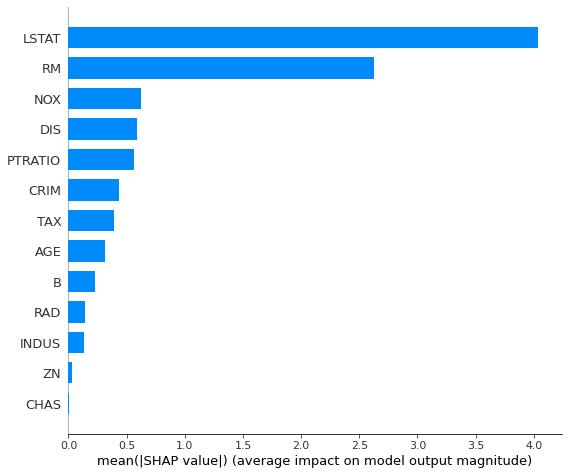

In [21]:
# visualize the feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

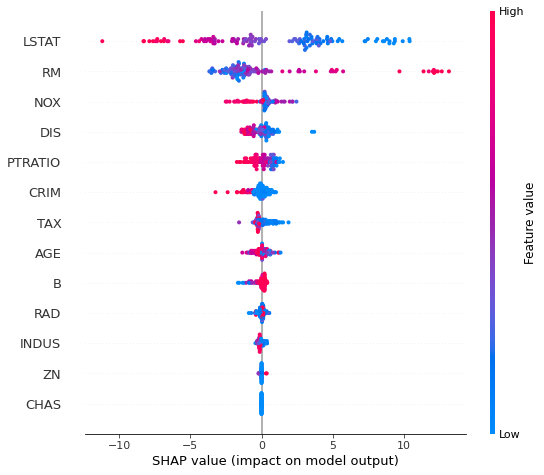

In [22]:
shap.summary_plot(shap_values, X_test)

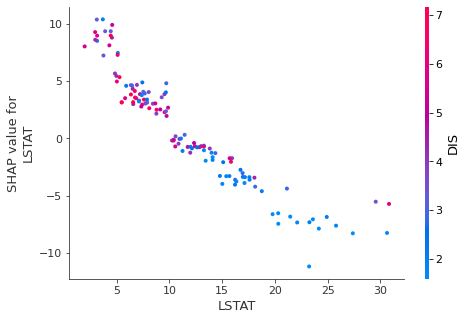

In [23]:
shap.dependence_plot("LSTAT", shap_values, X_test)